In [1]:
# solve imports and reload
import os
cwd = os.getcwd()
import sys
sys.path = [cwd] + sys.path
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np

# internal imports
import data
import evaluation
import visualization
import geometry
import graph_cuts
import utils

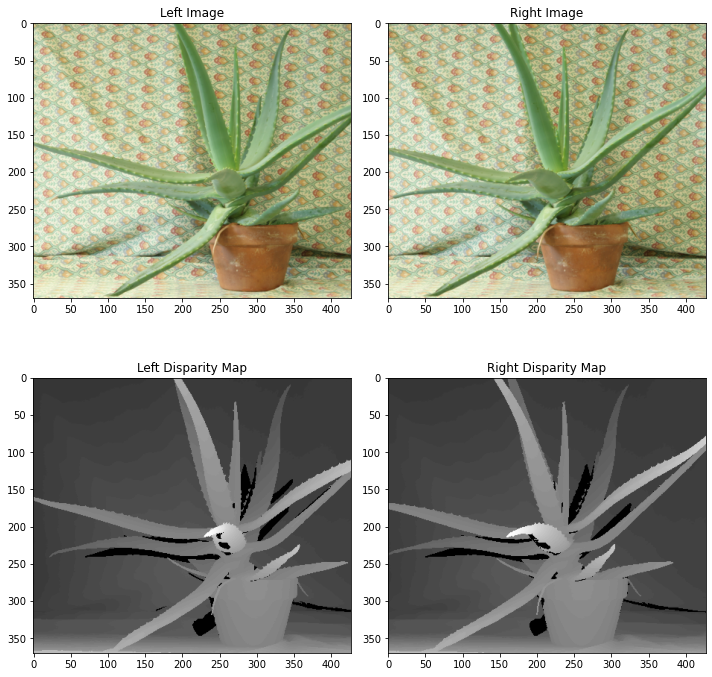

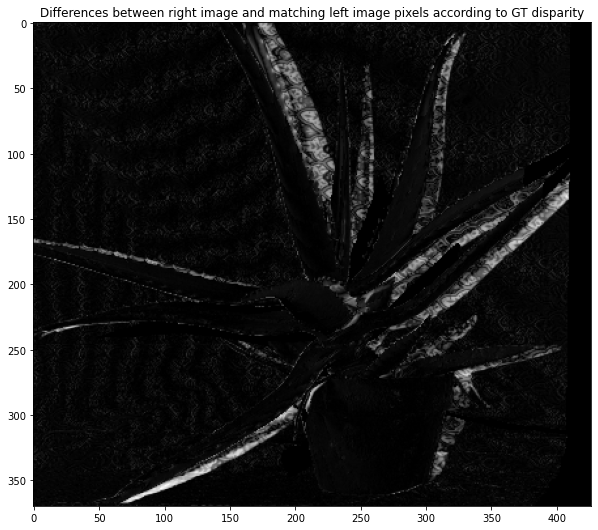

In [2]:
"""			3.1  Sanity Check			"""
# choose scene
chosen_scene = data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX]
# get images and gt disparities of scene
img_l, img_r = data.get_scene_images(chosen_scene)
d_l, d = data.get_scene_disparities(chosen_scene)
# visualize images and gt disparities
visualization.plot_scene(img_l, img_r, d_l, d)
# visualize a validation of gt disparities
differences_image = evaluation.get_disparity_rgb_distances(img_l, img_r, d)
visualization.plot_image(differences_image, "Differences between right image and matching left image pixels according to GT disparity")

In [3]:
"""			3.2  3D Plot				"""
# extract constants
h, w = img_r.shape[:2]
x_0, y_0 = geometry.get_image_center(h=h, w=w)
# get camera matrices for the two views
P_r, K_r = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
										x_0=x_0, y_0=y_0)
P_l, K_l = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=0,
										x_0=x_0, y_0=y_0)
# calculate 3d points from the two views
points_r = geometry.get_3d_points_from_disparities(disparity_map=d,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=True)
points_l = geometry.get_3d_points_from_disparities(disparity_map=d_l,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=False)
points_all = np.concatenate((points_l.reshape(4, -1), points_r.reshape(4, -1)), axis=1)
point_colors_all = np.concatenate((img_l.reshape(-1, 3), img_r.reshape(-1, 3)), axis=0)
# plot the 3D points and the camera
utils.plot_cameras(P=np.stack((P_l, P_r), axis=0),
				   K=np.stack((K_l, K_r), axis=0),
				   X=points_all,
				   title="3.2_3D_plot_reconstruction",
				   point_colors=point_colors_all)


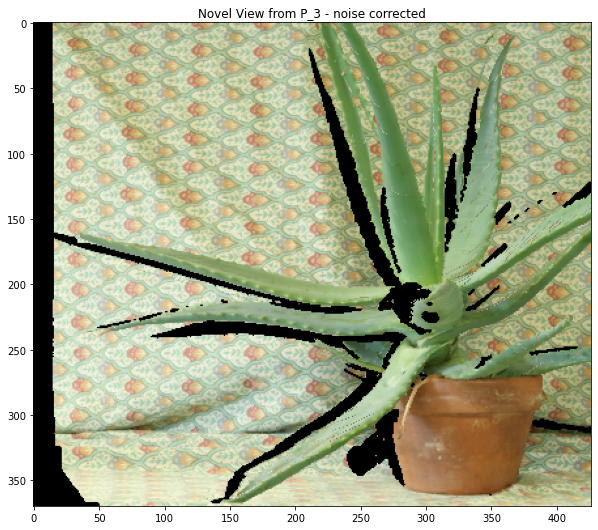

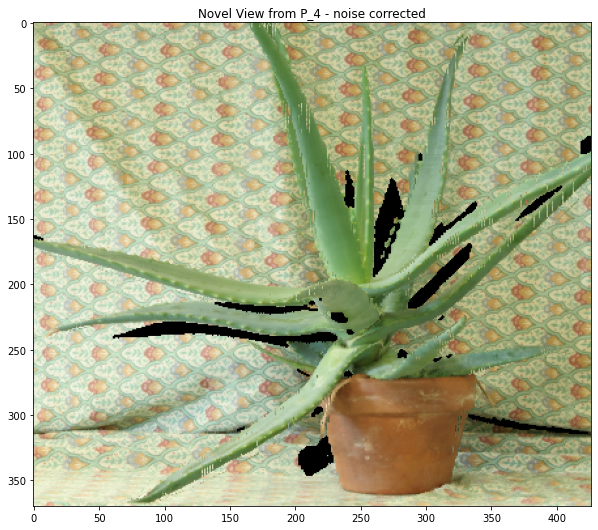

In [4]:
"""			3.3  Novel View				"""
# get camera matrices for the two views
P_3, K_3 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=-data.BASELINE,
										x_0=x_0, y_0=y_0)
P_4, K_4 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE/2,
										x_0=x_0, y_0=y_0)
# generate the novel view image
novel_image_3 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_3, h=h, w=w)
novel_image_4 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_4, h=h, w=w)
# clean the novel view image
cleaned_novel_image_3 = geometry.remove_black_stripes(novel_image_3)
cleaned_novel_image_4 = geometry.remove_black_stripes(novel_image_4)
# show the novel view image
visualization.plot_image(cleaned_novel_image_3 / 255, title="Novel View from P_3 - noise corrected")
visualization.plot_image(cleaned_novel_image_4 / 255, title="Novel View from P_4 - noise corrected")


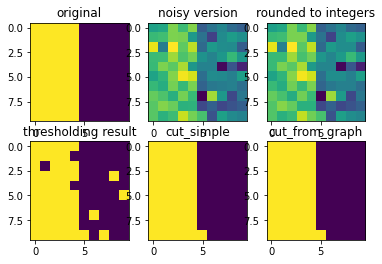

[[-23  -8   0]
 [ -8 -23  -8]
 [  0  -8 -23]]


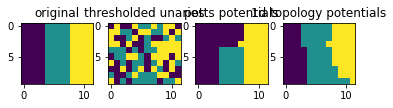

In [5]:
"""				4.1  PYGCO				"""
from pygco import cut_from_graph
import example


--------------------------------------------------
Scene Aloe:
accuracy = 2.945 
outlier_ration = 10.9%


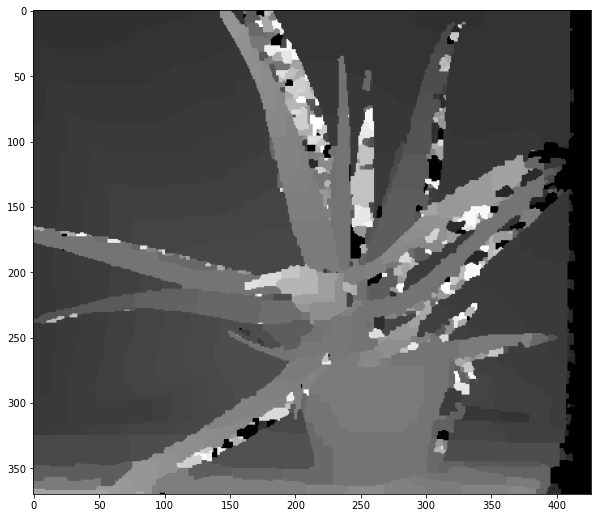

--------------------------------------------------
Scene Rocks1:


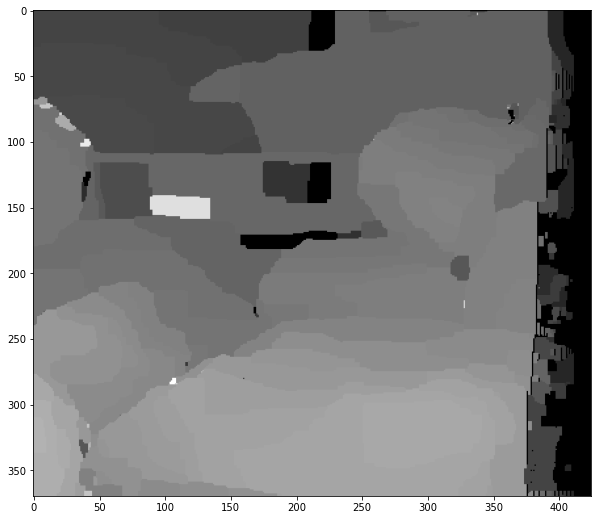

In [6]:
"""			4.2  Baseline solution		"""
K = 20
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.2")


In [7]:
"""			4.3  Improvements			"""

'\t\t\t4.3  Improvements\t\t\t'

######## 4.3.a - pairwise_cost_l1 - K*|i-j| ########
--------------------------------------------------
Scene Aloe:
accuracy = 1.294 
outlier_ration = 8.8%


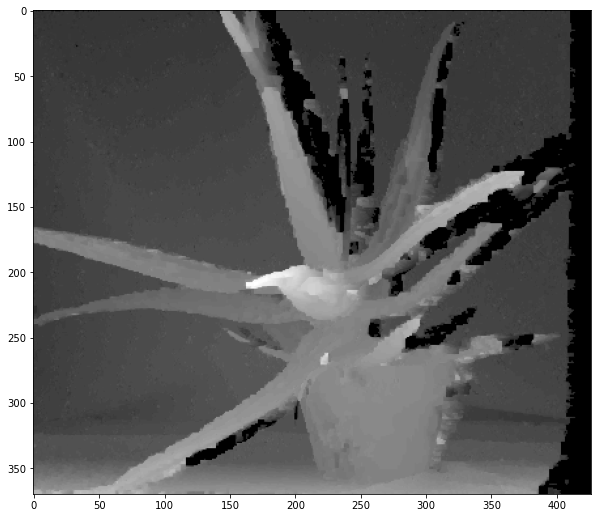

--------------------------------------------------
Scene Rocks1:


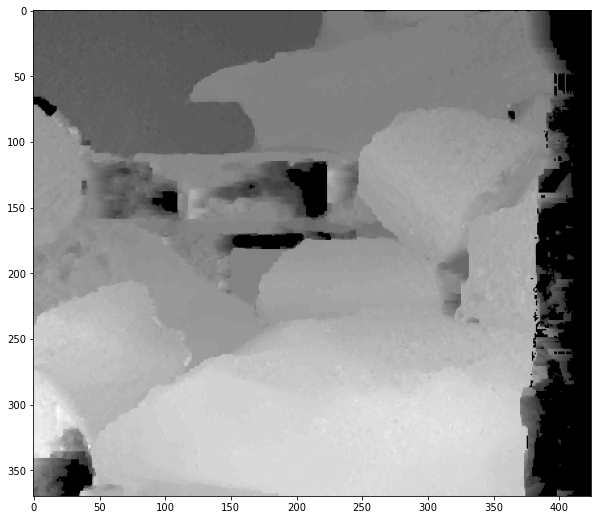

######## 4.3.a - pairwise_cost_l1_saturated - min{ K*|i-j| , M } ########
--------------------------------------------------
Scene Aloe:
accuracy = 1.176 
outlier_ration = 7.4%


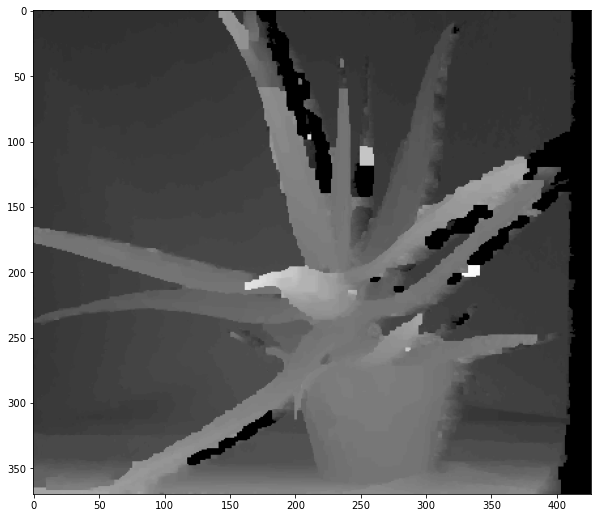

--------------------------------------------------
Scene Rocks1:


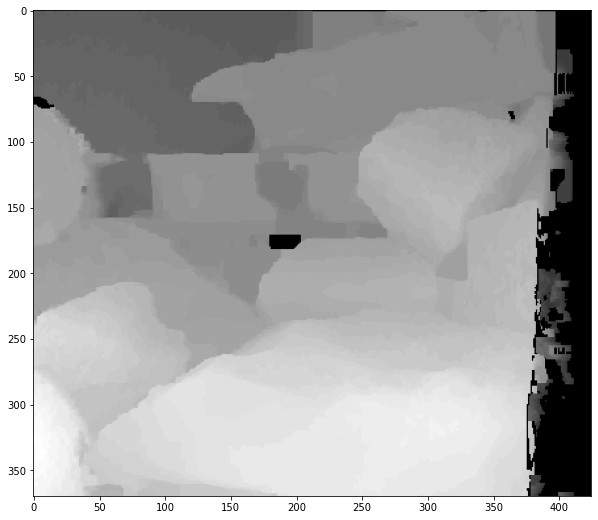

In [8]:
print("######## 4.3.a - pairwise_cost_l1 - K*|i-j| ########", flush=True)
K = 1
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")

print("######## 4.3.a - pairwise_cost_l1_saturated - min{ K*|i-j| , M } ########", flush=True)
K = 3
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")


######## 4.3.b - unary_cost_colored ########
--------------------------------------------------
Scene Aloe:
accuracy = 1.145 
outlier_ration = 7.1%


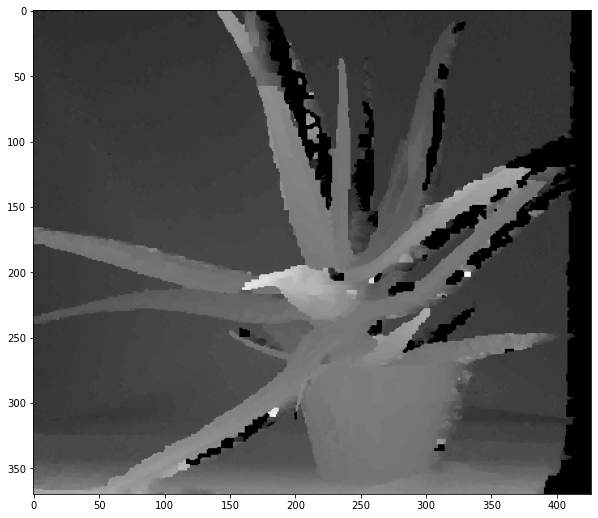

--------------------------------------------------
Scene Rocks1:


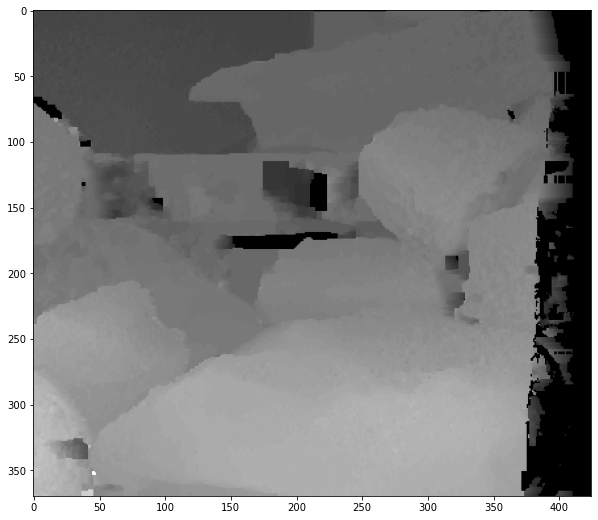

In [9]:
print("######## 4.3.b - unary_cost_colored ########", flush=True)
K = 3
scale = 2
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_colored,
													get_unary_cost_kwargs=dict({"scale": scale}),
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")


######## 4.3.c - unary_cost_patches - SAD distance ########
--------------------------------------------------
Scene Aloe:
accuracy = 1.968 
outlier_ration = 10.2%


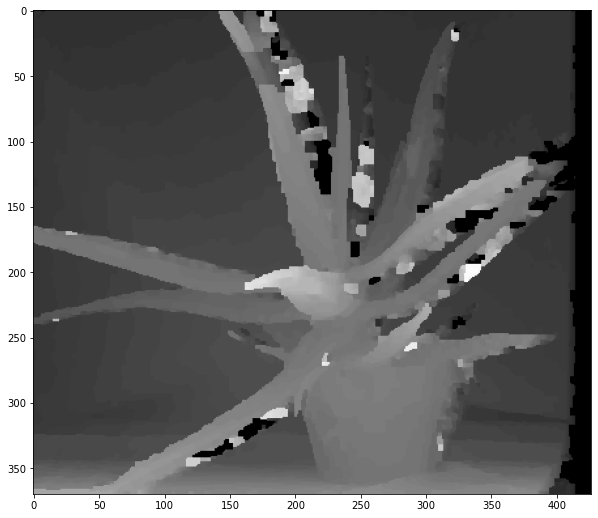

--------------------------------------------------
Scene Rocks1:


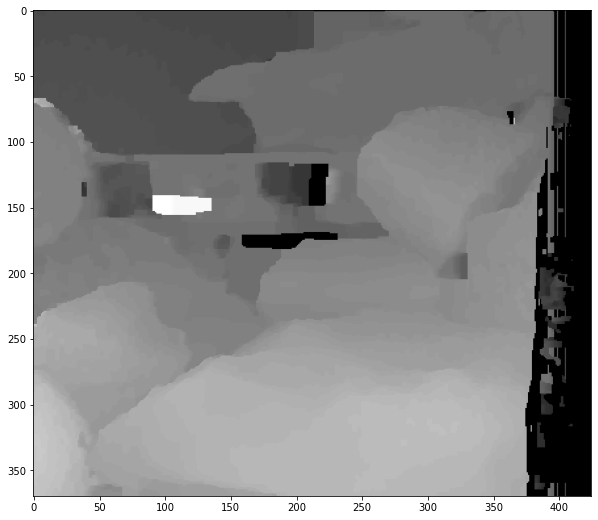

######## 4.3.c - unary_cost_patches - NCC distance ########
--------------------------------------------------
Scene Aloe:


C:\Git\MVGFinalProject\graph_cuts.py:68: RuntimeWarning:

Mean of empty slice



accuracy = 1.362 
outlier_ration = 8.0%


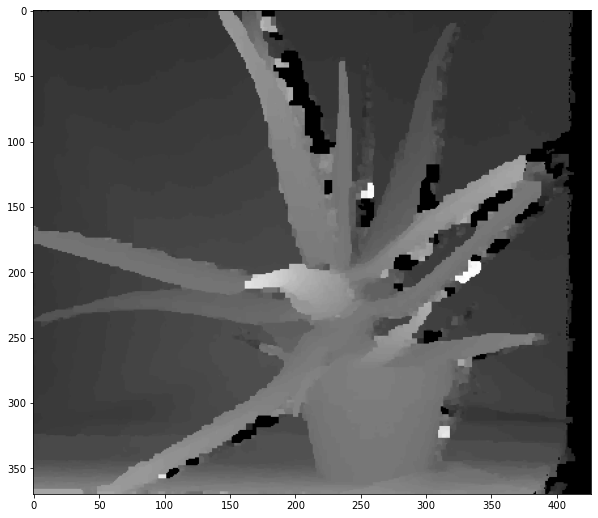

--------------------------------------------------
Scene Rocks1:


C:\Git\MVGFinalProject\graph_cuts.py:59: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\user\anaconda3\envs\projectMVG\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning:

invalid value encountered in reduce

C:\Git\MVGFinalProject\graph_cuts.py:66: RuntimeWarning:

invalid value encountered in multiply



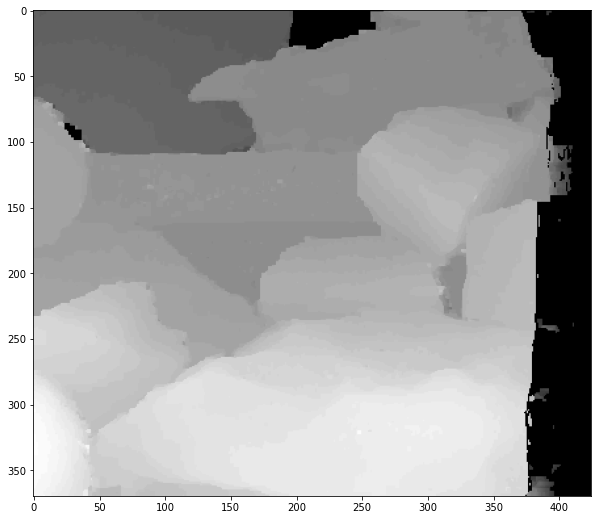

In [10]:
print("######## 4.3.c - unary_cost_patches - SAD distance ########", flush=True)
K = 3
r = 3
scale = 0.2
dist_method = "SAD"
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_patches,
													get_unary_cost_kwargs=dict({"kernel_size": r, "scale": scale, "dist_method": dist_method}),
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3", plot_results=True)

print("######## 4.3.c - unary_cost_patches - NCC distance ########", flush=True)
K = 3
r = 3
scale = 30
dist_method = "NCC"
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_patches,
													get_unary_cost_kwargs=dict({"kernel_size": r, "scale": scale, "dist_method": dist_method}),
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3", plot_results=True)

######## 4.3.d - unary_cost_NN_features ########
--------------------------------------------------
Scene Aloe:


C:\Users\user\anaconda3\envs\projectMVG\lib\site-packages\torch\nn\functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)

C:\Users\user\anaconda3\envs\projectMVG\lib\site-packages\torch\nn\functional.py:3613: UserWarning:

Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



accuracy = 1.446 
outlier_ration = 7.4%


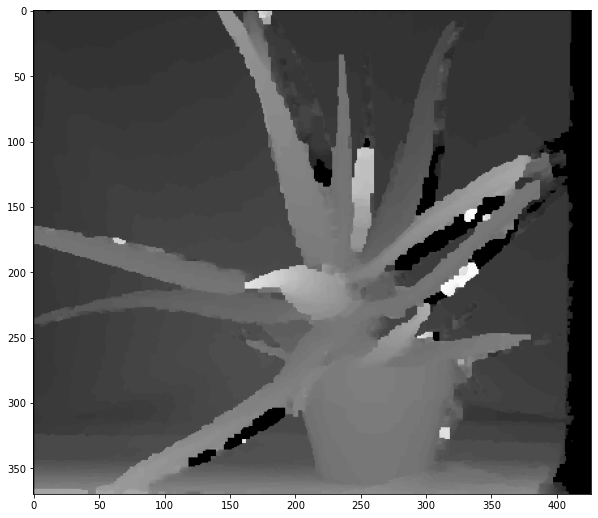

--------------------------------------------------
Scene Rocks1:


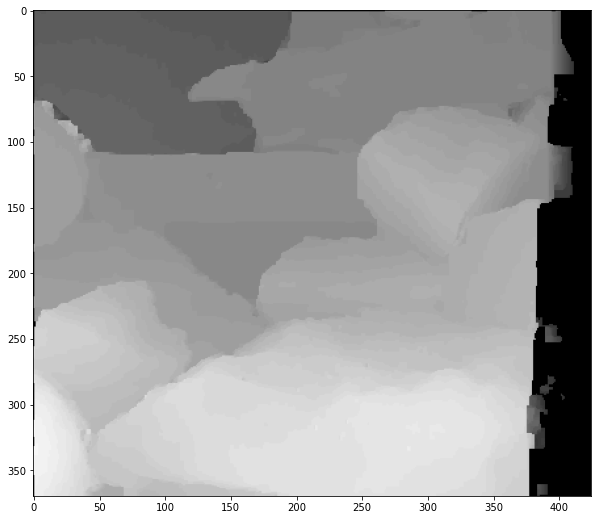

In [11]:
print("######## 4.3.d - unary_cost_NN_features ########", flush=True)
K = 3
model = "vgg"
scale = 0.15
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_features,
													get_unary_cost_kwargs=dict({"scale": scale, "model": model}),
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3", plot_results=True)

######## 4.3.e - unary_cost_colors_NN_features_combined ########
--------------------------------------------------
Scene Aloe:
accuracy = 1.143 
outlier_ration = 7.0%


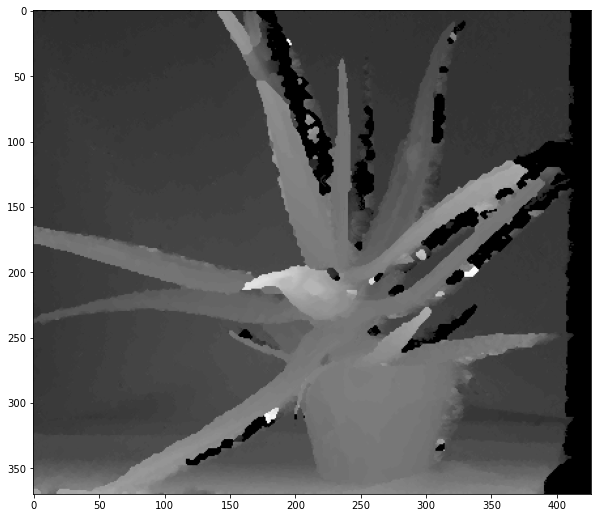

--------------------------------------------------
Scene Rocks1:


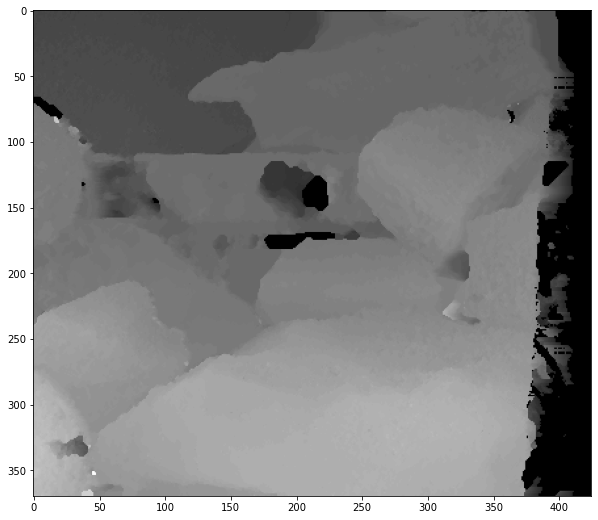

In [12]:
print("######## 4.3.e - unary_cost_colors_NN_features_combined ########", flush=True)
K = 3
scale = 0.3
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_all_surrounding_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_colors_features_combined,
													get_unary_cost_kwargs=dict({"colored_scale" : 10 * scale, "features_scale" : 1 * scale, "model": "vgg"}),
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")